In [63]:
using PyPlot
using Distributions
using LinearAlgebra
using Flux
using Parameters: @with_kw;

In [64]:
#Hyperparameters
n = 1000
N = 4000
σₐ = 0.003
k_range = 12
k_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] #November 3
k_list_lite = [i for i in 1:k_range];

In [65]:
#Functions
function plot_data(data,classes,alpha=1.0)
    markers = ["o","*"]
    colors = ["blue","green"]
    for i=1:2
        mask = [classes[j] == i for j in 1:length(classes)]
        scatter(data[:,1][mask],data[:,2][mask],c=colors[i],alpha=alpha,marker=markers[i],zorder=3)
    end
end;

function unpack(Θ,k)
    m = length(Θ)
    h = 2*k
    Wₕ = reshape(Θ[1:h], k, 2);   
    bₕ = reshape(Θ[h+1:h+k], k)
    #bₕ = reshape(zeros(k), k)
    
    Wₒ = reshape(Θ[h+k+1:m-1], 1, k);
    bₒ = Θ[m]
    #bₒ = 0.0
      
    return Wₕ, bₕ, Wₒ, bₒ
end

function data_labeller(y::Array{Float64})
    labels = [y[i] > 0.5 ? 2 : 1 for i=1:length(y)]
    return labels
end

mₖ(k) = k*4 + 1;

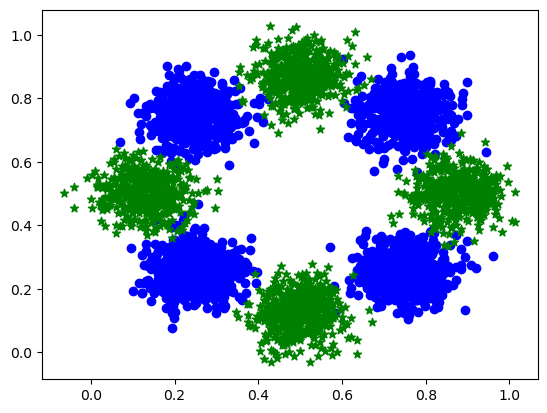

(2, 4000)(4000,)

In [66]:
#Scale up - Fixed Separable Data - Multi-XOR Data
function real_data(N::Int, modes::Int, σ::Float64)
    μ₁ = [0.25, 0.25]
    μ₂ = [0.5, 0.125]
    μ₃ = [0.25, 0.75]
    μ₄ = [0.125, 0.50]
    μ₅ = [0.75, 0.75]
    μ₆ = [0.50, 0.875]
    μ₇ = [0.75, 0.25]
    μ₈ = [0.875, 0.50]
    μ = [μ₁, μ₂, μ₃, μ₄, μ₅, μ₆, μ₇, μ₈]
    Σ = [[σ, 0] [0, σ]]
    
    all_samples = zeros(Float64, (N*modes, 2))
    classes = zeros(Int, (N*modes))
    
    for i = 1:modes
        dist = MvNormal(μ[i], Σ)
        sample = rand(dist, N)::Matrix
        #scatter(sample[1,:],sample[2,:])
        all_samples[(i-1)*N+1:i*N,:] = transpose(sample)
        classes[(i-1)*N+1:i*N] = fill(i, N)
        classes = float(classes)
    end
    return all_samples, classes
end
    
data_raw, classes = real_data(Int(N/8), 8, σₐ);
classes = [(i+1) % 2 + 1 for i in classes]
y = classes .- 1

plot_data(data_raw,classes)
data = transpose(data_raw)
x = data
x_raw = data_raw
print(size(data))
print(size(y))

In [67]:
#Neural Nets with Different k
function model(k::Int) 
    return Chain(
  Dense(2, k, relu),
  Dense(k, 1, σ))
end

model (generic function with 1 method)

In [74]:
## utility functions

num_params(model) = sum(length, Flux.params(model)) 

round4(x) = round(x, digits=4)

loss(y_hat, y) = Flux.binarycrossentropy(y_hat, y)

function getdata(x,y)
    # Reshape Data in order to flatten each image into a linear array
    xtrain = Flux.flatten(x)

    # One-hot-encode the labels
    ytrain = Flux.flatten(y)

    # Batching
    train_data = Flux.Data.DataLoader(xtrain, ytrain, batchsize=1000, shuffle=true)

    return train_data
end

#w = getdata(x,y)
#print(w)

function eval_loss_accuracy(x, y, net)
    l = 0.0
    accs = 0
    ntot = 0
    loss = 0
    z = net(x)
    z = [round(z[i]) for i=1:length(z)]
    targets = [[z[i] == y[i] for i=1:length(y)]]
    acc = sum(targets[1])
    #println(acc)
    #for i in 1:length(y)
        #ŷ = (net(x[:,i]))[1]
        #l += loss(ŷ, y[i])   
        #acc = (round(ŷ) == y[i])
        #accs += acc
    #end
    return (loss = l/ntot |> round4, acc = acc/length(y)*100)
end

function loss_all(dataloader, model)
    l = 0f0
    for (x,y) in dataloader
        l += Flux.Losses.logitbinarycrossentropy(model(x), y)
    end
    l/length(dataloader)
end

losses = []
accs = []

@with_kw mutable struct Args
    η::Float64 = 3e-4       # learning rate
    batchsize::Int = 1024   # batch size
    epochs::Int = 10        # number of epochs
    device::Function = gpu  # set as gpu, if gpu available
end

function train(x,y,m,epochs)
    # Load Data
    train_data = getdata(x,y)

    # Construct model
    #m = model(k)
    loss(x,y) = Flux.Losses.logitbinarycrossentropy(m(x), y)
    
    ## Training
    opt = ADAM(0.001)

    for i=1:epochs
        Flux.train!(loss, Flux.params(m), train_data, opt)
        loss1, acc = eval_loss_accuracy(x,y,m)
        push!(accs, acc)
        if i%100 == 0
            loss1 = loss_all(train_data, m)
            push!(losses,loss1)
            println(acc)
            #println(Flux.params(m))
        end
        #println(Flux.params(m))
    end
    return m, losses, accs
end

m3 = model(3)
m4 = model(4)

Chain(Dense(2, 4, relu), Dense(4, 1, σ))

In [75]:
m32, losses3, accs3 = train(x,y,m3,20000);

50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.349999999999994
53.625
55.75
56.725
57.15
57.425000000000004
57.525000000000006
57.725
57.925000000000004
58.074999999999996
58.199999999999996
58.25
58.325
58.325
58.3
58.275
58.35
58.35
58.35
58.35
58.35
58.35
58.35
58.35
58.35
58.599999999999994
58.85
59.099999999999994
59.199999999999996
59.375
59.599999999999994
59.75
60.050000000000004
60.275
60.650000000000006
60.85
61.199999999999996
61.4
61.575
61.724999999999994
61.925
61.975
62.025
62.050000000000004
62.125
62.2
62.224999999999994
62.25000000000001
62.275000000000006
62.275000000000006
62.275000000000006
62.25000000000001
62.3
62.324999999999996
62.324999999999996
62.324999999999996
62.324999999999996
62.324999999999996
62.324999999999996
62.324999999999996
62.324999999999996
62.324999999999996
62.35000000000001
62.35000000000001
62.35000000000001
62.35000000000001
62.35000000000001
62.35000000000001
62.35000000000001
62.35000000000001
62.35000000000001
62.35000000000001
6

In [76]:
m42, losses4, accs4 = train(x,y,m4,20000)

50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.075
52.175000000000004
54.625
55.625
56.15
56.574999999999996
56.599999999999994
56.925000000000004
57.025000000000006
57.05
57.25
57.325
57.375
57.375
57.425000000000004
57.425000000000004
57.425000000000004
57.49999999999999
57.599999999999994
57.65
57.725
57.699999999999996
57.699999999999996
57.699999999999996
57.675
57.725
57.725
57.699999999999996
57.725
57.725
57.725
57.75
57.775
57.775
57.775
57.775
57.775
57.775
57.775
57.8
57.8
57.775
57.8
57.8
57.8
57.8
57.8
57.775
57.75
57.775
57.775
57.775
57.775
57.775
57.775
57.775
57.775
57.775
57.775
57.775
57.75
57.75
57.75
57.75
57.75
57.75
57.75
57.75
57.75
57.775
57.775
57.775
57.75
57.75
57.75
57.75
57.75
57.775
57.775
57.775
57.775
57.75
57.775
57.775
57.775
57.775
57.8
57.8
57.8
57.8
57.8
57.8
57.825
57.8
57.8
57.825
57.825
57.825
57.825
57.8
57.8
57.825
57.825
57.825
57.825
57.825
57.825
57.825
57.825
57.825
57.825
57.825
57.825
57.825
57.825
57.825
57.825
57.825
57.8
57.8
57.8
57.8
57

(Chain(Dense(2, 4, relu), Dense(4, 1, σ)), Any[0.6949572137482465, 0.6934760085307062, 0.69319927913812, 0.6931117812660523, 0.6930688453159527, 0.6930332545147395, 0.692985003225971, 0.6928926884172543, 0.6926541214190947, 0.6916867685362377  …  0.6667083311347596, 0.6667079128241333, 0.6667073958243876, 0.6667069777009207, 0.6667066333954133, 0.6667060426020351, 0.6667055835555221, 0.6667051452713265, 0.666704742963373, 0.6667043687593794], Any[50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0  …  57.825, 57.825, 57.825, 57.825, 57.825, 57.825, 57.825, 57.825, 57.825, 57.825])

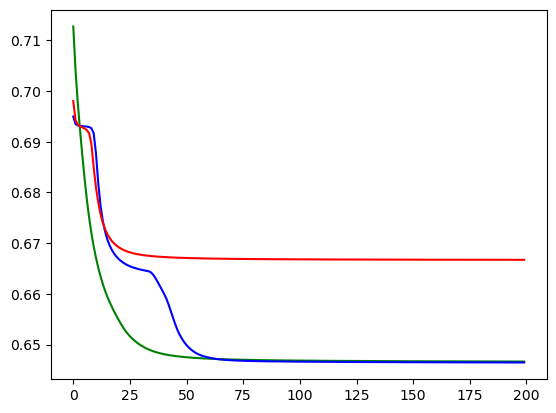

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f0ed22ee310>

In [84]:
plot(losses2[401:600], c="green")
plot(losses3[1:200], c="blue")
plot(losses4[201:400], c="red")

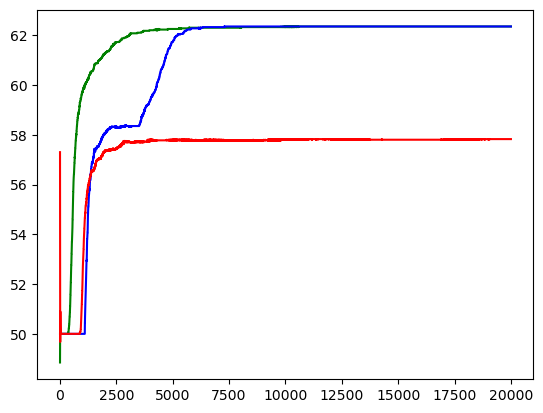

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f0ed2bcdad0>

In [83]:
plot(accs2[40001:60000], c="green")
plot(accs3[1:20000], c="blue")
plot(accs4[20001:40000], c="red")

In [82]:
m2 = model(2)
m22, losses2, accs2 = train(x,y,m2,20000)

50.0
50.0
50.0
50.3
52.75
56.10000000000001
57.775
58.8
59.35
59.699999999999996
60.0
60.199999999999996
60.4
60.550000000000004
60.699999999999996
60.875
60.95
61.050000000000004
61.175000000000004
61.275
61.35
61.4
61.550000000000004
61.625
61.724999999999994
61.724999999999994
61.8
61.875
61.9
61.95
62.025
62.075
62.075
62.075
62.1
62.1
62.175000000000004
62.175000000000004
62.175000000000004
62.2
62.2
62.224999999999994
62.2
62.224999999999994
62.224999999999994
62.224999999999994
62.224999999999994
62.25000000000001
62.25000000000001
62.25000000000001
62.25000000000001
62.25000000000001
62.25000000000001
62.275000000000006
62.275000000000006
62.275000000000006
62.275000000000006
62.3
62.3
62.3
62.3
62.3
62.3
62.3
62.3
62.3
62.3
62.3
62.3
62.3
62.3
62.3
62.3
62.3
62.3
62.3
62.3
62.3
62.3
62.3
62.324999999999996
62.324999999999996
62.324999999999996
62.324999999999996
62.324999999999996
62.324999999999996
62.324999999999996
62.324999999999996
62.324999999999996
62.324999999999996
62

(Chain(Dense(2, 2, relu), Dense(2, 1, σ)), Any[0.6949572137482465, 0.6934760085307062, 0.69319927913812, 0.6931117812660523, 0.6930688453159527, 0.6930332545147395, 0.692985003225971, 0.6928926884172543, 0.6926541214190947, 0.6916867685362377  …  0.6466438501426085, 0.6466427946012854, 0.6466417705654723, 0.6466407473144116, 0.6466397339528813, 0.646638746979116, 0.6466377641946646, 0.6466367460455119, 0.6466358101700517, 0.6466347648977591], Any[50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0  …  62.35000000000001, 62.35000000000001, 62.35000000000001, 62.35000000000001, 62.35000000000001, 62.35000000000001, 62.35000000000001, 62.35000000000001, 62.35000000000001, 62.35000000000001])